In [1]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from collections import Counter
import networkx as nx 

In [2]:
try:
    with open('community_detection.json', 'r', encoding='utf-8') as f:
        community_data = json.load(f)
except UnicodeDecodeError:
    with open('community_detection.json', 'r', encoding='ISO-8859-1') as f:
        community_data = json.load(f)

try:
    with open('user_features.json', 'r', encoding='utf-8') as f:
        user_features = json.load(f)
except UnicodeDecodeError:
    with open('user_features.json', 'r', encoding='ISO-8859-1') as f:
        user_features = json.load(f)

print(f"Number of nodes in community data: {len(community_data)}")
print(f"Number of nodes in user features: {len(user_features)}")
print(f"Number of communities: {len(set(community_data.values()))}")

Number of nodes in community data: 81306
Number of nodes in user features: 81306
Number of communities: 73


In [3]:
# Sample number of communities and nodes per community to analyze
num_communities = 20  
nodes_per_community = 250 

# community IDs
unique_communities = list(set(community_data.values()))

sampled_communities = random.sample(unique_communities, num_communities)
sampled_nodes = {}
for community_id in sampled_communities:
    community_nodes = [node for node, comm in community_data.items() if comm == community_id]
    sampled_nodes[community_id] = random.sample(community_nodes, min(len(community_nodes), nodes_per_community))

sampled_nodes

{19: ['118148003',
  '344522302',
  '238660875',
  '184453159',
  '18376795',
  '108181916',
  '16548256',
  '64636724',
  '76097386',
  '414716830',
  '337297720',
  '44146933',
  '141030609',
  '26288526',
  '21095472',
  '82980421',
  '64769052',
  '366606110',
  '222180958',
  '37848814',
  '116038405',
  '59347192',
  '18816738',
  '488701186',
  '306041373',
  '171694583',
  '24581048',
  '31547690',
  '67732103',
  '43390066',
  '147253547',
  '72067721',
  '27348403',
  '20695474',
  '441143941',
  '18228898',
  '781730',
  '41592699',
  '24606439',
  '19035168',
  '30782495',
  '18422387',
  '55109529',
  '18776893',
  '71028797',
  '43638282',
  '190386658',
  '19566101',
  '164063217',
  '56516742',
  '210729842',
  '540206854',
  '20545055',
  '22143745',
  '231805608',
  '21828103',
  '44474106',
  '117403234',
  '22644308',
  '53317887',
  '25150434',
  '216845822',
  '24025409',
  '21323946',
  '24275589',
  '34689363',
  '41368231',
  '275333376',
  '3941241',
  '152071

In [4]:
# Print selected users and features in communities
for community_id, nodes in sampled_nodes.items():
    print(f"\nCommunity {community_id}:")
    for node in nodes:
        features = user_features.get(str(node), [])
        print(f"  Node {node} features: {features}")


Community 19:
  Node 118148003 features: ['s', '']
  Node 344522302 features: ['@DanielAnthony86', '@Haileebopp', '@ItsJDClay', '@danielanthony86', '@haileebopp', '@isLexSmith', '@iscorey', '@istommy2118', '@itsjdclay']
  Node 238660875 features: ['@Brit1988', '@Kaanan_Is_LTL', '@deycallME_Dis']
  Node 184453159 features: []
  Node 18376795 features: ['@YouTube', '#MMG', '@rickyrozay:', '@BSLADE', '@IAmLaTocha', '@MoneyGraphics', '@TonyGaskins']
  Node 108181916 features: ['@globovision:']
  Node 16548256 features: []
  Node 64636724 features: ['#shoutout', '#Winning', '#Virgo', '@XSTROLOGY', '#nw', '@P_Smiles', '@T_D_Hanner', '@_Southrn_Belle_']
  Node 76097386 features: ['#3', '@youtube', '#NowPlaying', '#soundcloud', '@106andpark', '@Power1051:', '@Mr_Dupri', '@Mr_Dupri:', '#THINK', '@ChrisetteM', '@Epic_Records', '@SpokenReasons', '#Friendfffans', '#SoSoDef', '#lifers', '@1AngelLTL:', '@2CHAINZ)', '@BHINESTHEREAL)-YES', '@DJFashoNC', '@DJMistaXclusive:', '@DONDRIA', '@Dondria', '@

In [5]:
# jaccard similarity
def calculate_jaccard(set1, set2):
    if not set1 and not set2:  # Both sets are empty
        return 0.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


In [6]:
similarity_scores = []
for community_id, nodes in sampled_nodes.items():
    # Calculate within-community similarity
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            features1 = set(user_features.get(str(nodes[i]), []))
            features2 = set(user_features.get(str(nodes[j]), []))
            similarity = calculate_jaccard(features1, features2)
            similarity_scores.append({'Community': community_id, 'Type': 'Within', 'Similarity': similarity})
    
    # Calculate between-community similarity
    other_nodes = [node for other_id, other_nodes in sampled_nodes.items() if other_id != community_id for node in other_nodes]
    for node1 in nodes:
        features1 = set(user_features.get(str(node1), []))
        for node2 in other_nodes:
            features2 = set(user_features.get(str(node2), []))
            similarity = calculate_jaccard(features1, features2)
            similarity_scores.append({'Community': community_id, 'Type': 'Between', 'Similarity': similarity})

similarity_df = pd.DataFrame(similarity_scores)
similarity_df


,Community,Type,Similarity
0,19,Within,0.0
1,19,Within,0.0
2,19,Within,0.0
3,19,Within,0.0
4,19,Within,0.0
...,...,...,...
18660584,56,Between,0.0
18660585,56,Between,0.0
18660586,56,Between,0.0
18660587,56,Between,0.0


In [7]:
# Calculate average similarities
average_similarities = similarity_df.groupby('Type')['Similarity'].mean().reset_index()

print("Average Similarities:")
print(average_similarities)

Average Similarities:
      Type  Similarity
0  Between    0.000681
1   Within    0.007227


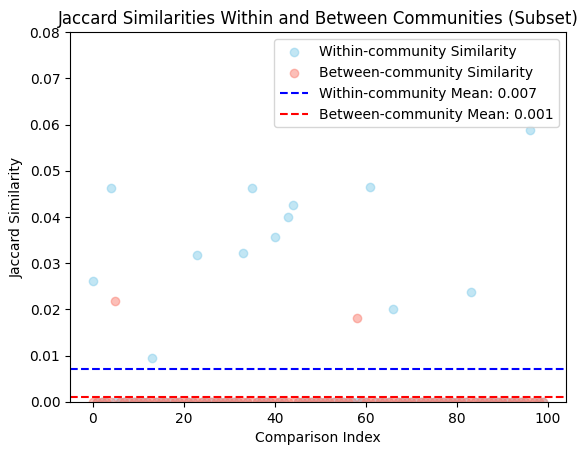

In [8]:
within_mean = average_similarities[average_similarities['Type'] == 'Within']['Similarity'].values[0]
between_mean = average_similarities[average_similarities['Type'] == 'Between']['Similarity'].values[0]

# Round the averages to thousandths place
within_mean = round(within_mean, 3)
between_mean = round(between_mean, 3)

# Sample size for plot - an equal number of 'Within' and 'Between' nodes
sample_size = 100 
within_sample_df = similarity_df[similarity_df['Type'] == 'Within'].sample(n=sample_size, random_state=42)
between_sample_df = similarity_df[similarity_df['Type'] == 'Between'].sample(n=sample_size, random_state=42)

# Extract similarities
within_similarities = within_sample_df['Similarity'].values
between_similarities = between_sample_df['Similarity'].values

# Plot
within_index = np.arange(len(within_similarities))
between_index = np.arange(len(between_similarities))
plt.scatter(within_index, within_similarities, color='skyblue', label='Within-community Similarity', alpha=0.5)
plt.scatter(between_index, between_similarities, color='salmon', label='Between-community Similarity', alpha=0.5)

# horizontal lines for the average similarities
plt.axhline(within_mean, color='blue', linestyle='--', label=f'Within-community Mean: {within_mean:.3f}')
plt.axhline(between_mean, color='red', linestyle='--', label=f'Between-community Mean: {between_mean:.3f}')

# Labels
plt.xlabel("Comparison Index")
plt.ylabel("Jaccard Similarity")
plt.title("Jaccard Similarities Within and Between Communities (Subset)")

plt.ylim(0, 0.08)  
plt.gca().yaxis.set_major_locator(MultipleLocator(0.01)) 
plt.legend()
plt.show()


In [9]:
# Define categories (tags, hashtags, and other)
categories = {
    "tags": lambda x: x.startswith("@"),  # mentions
    "hashtags": lambda x: x.startswith("#"),  # hashtags
    "other": lambda x: not x.startswith("@") and not x.startswith("#")  # Everything else
}

# Count feature types in each community
category_counts = {community_id: Counter() for community_id in sampled_nodes}

for community_id, nodes in sampled_nodes.items():
    for node in nodes:
        features = user_features.get(str(node), [])
        for feature in features:
            for category, condition in categories.items():
                if condition(feature):
                    category_counts[community_id][category] += 1

# category frequencies for each community
category_counts


{19: Counter({'tags': 2165, 'hashtags': 771, 'other': 6}),
 18: Counter({'tags': 3094, 'hashtags': 1206, 'other': 1}),
 28: Counter({'tags': 3314, 'hashtags': 713, 'other': 1}),
 42: Counter({'tags': 2126, 'hashtags': 496}),
 38: Counter({'tags': 512, 'hashtags': 50}),
 69: Counter({'tags': 3541, 'hashtags': 996}),
 55: Counter({'tags': 5579, 'hashtags': 1309}),
 3: Counter({'tags': 2692, 'hashtags': 509}),
 11: Counter({'tags': 3770, 'hashtags': 808, 'other': 3}),
 13: Counter({'tags': 2944, 'hashtags': 936}),
 20: Counter({'tags': 3855, 'hashtags': 1718, 'other': 1}),
 49: Counter({'tags': 1437, 'hashtags': 224, 'other': 2}),
 43: Counter({'tags': 2282, 'hashtags': 749, 'other': 1}),
 63: Counter({'tags': 212, 'hashtags': 104}),
 41: Counter({'tags': 1199, 'hashtags': 691}),
 25: Counter({'tags': 2938, 'hashtags': 773}),
 12: Counter({'tags': 3743, 'hashtags': 988, 'other': 3}),
 1: Counter({'tags': 3208, 'hashtags': 639, 'other': 1}),
 0: Counter({'tags': 2850, 'hashtags': 448}),
 5

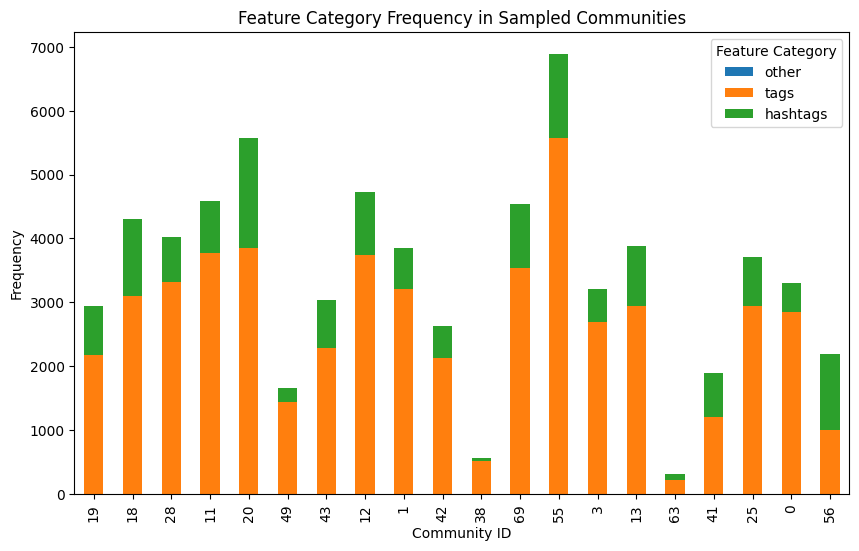

In [10]:
category_df = pd.DataFrame.from_dict(category_counts, orient='index').fillna(0)

# Plot
category_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Feature Category Frequency in Sampled Communities")
plt.xlabel("Community ID")
plt.ylabel("Frequency")
plt.legend(title="Feature Category")
plt.show()


Category Percentages: {'tags': 78.42442815772101, 'hashtags': 21.53854926091363, 'other': 0.03702258136535425}


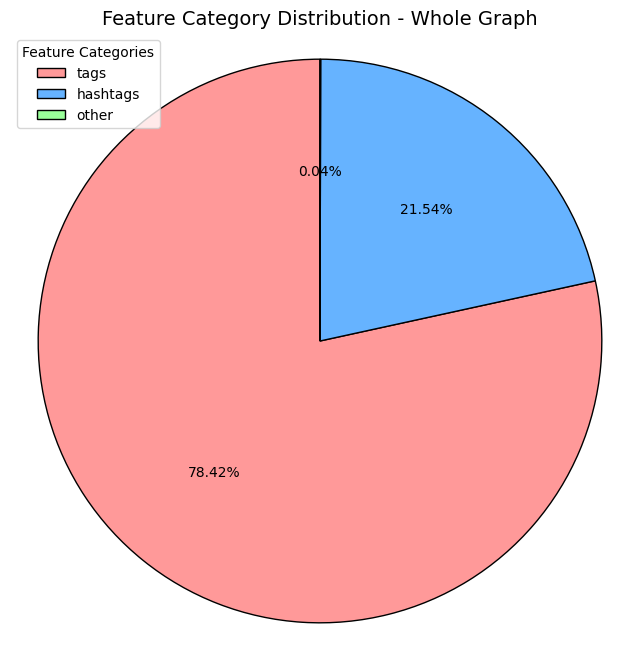

In [11]:
with open('graph_layout.json', 'r', encoding='utf-8') as f:
    layout_data = json.load(f)

# Create a graph
G = nx.Graph()
for node in layout_data.keys():
    G.add_node(int(node))

all_nodes = list(G.nodes)

# categories (tags, hashtags, and other)
categories = {
    "tags": lambda x: x.startswith("@"),  # Mentions/tags
    "hashtags": lambda x: x.startswith("#"),  # Hashtags
    "other": lambda x: not x.startswith("@") and not x.startswith("#")  # Everything else
}

# Count feature types across the graph
feature_counts = Counter()
for node in all_nodes:  
    features = user_features.get(str(node), [])  
    for feature in features:
        for category, condition in categories.items():
            if condition(feature):
                feature_counts[category] += 1

# total number of features
total_features = sum(feature_counts.values())

# percentages for each category
category_percentages = {category: count / total_features * 100 for category, count in feature_counts.items()}
print(f"Category Percentages: {category_percentages}")

labels = category_percentages.keys()
sizes = category_percentages.values()
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Colors for categories

# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, colors=colors, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

plt.legend(labels=labels, loc='upper left', title='Feature Categories', fontsize=10, frameon=True)
plt.title('Feature Category Distribution - Whole Graph', fontsize=14)
plt.axis('equal')

plt.show()



   Community     Node1      Node2                                Category  \
0         42  20611743  126434914  {'tags': 0, 'hashtags': 0, 'other': 0}   
1         42  20611743   13482842  {'tags': 1, 'hashtags': 0, 'other': 0}   
2         42  20611743  409011884  {'tags': 1, 'hashtags': 0, 'other': 0}   
3         42  20611743   13395742  {'tags': 1, 'hashtags': 0, 'other': 0}   
4         42  20611743  422362699  {'tags': 0, 'hashtags': 0, 'other': 0}   

                                     Common_Features  
0                                                 {}  
1             {@poketronik, @Litzia:, @PMShappyhaze}  
2                                      {@PunisherIV}  
3  {@PMShappyhaze, @Azevrec, @akirareiko, @Aftash...  
4                                                 {}  
Category Counts of Similarities:
tags        10256
hashtags    13983
other          18
dtype: int64
Category Percentages of Similarities:
tags        42.280579
hashtags    57.645216
other        0.074205
dty

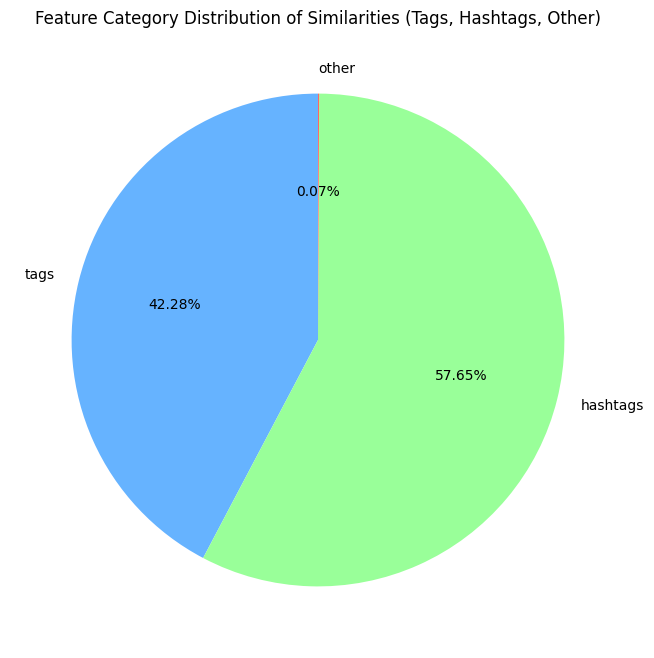

In [12]:
random.seed(42)

# smaller sample size
sample_community_size = 10  
sample_node_size = 100      

# Sample a subset of communities and nodes
sampled_communities_subset = random.sample(list(sampled_nodes.items()), sample_community_size)
sampled_nodes_subset = {community_id: random.sample(nodes, min(sample_node_size, len(nodes))) 
                        for community_id, nodes in sampled_communities_subset}

categories = {
    "tags": lambda x: x.startswith("@"),
    "hashtags": lambda x: x.startswith("#"),
    "other": lambda x: not x.startswith("@") and not x.startswith("#")  # Everything else
}

# categorize features 
def categorize_features(features):
    categories_for_features = {'tags': 0, 'hashtags': 0, 'other': 0}
    for feature in features:
        for category, condition in categories.items():
            if condition(feature):
                categories_for_features[category] += 1
    return categories_for_features

def calculate_similarity_and_categories(node1, node2, community_id):
    features1 = set(user_features.get(str(node1), []))
    features2 = set(user_features.get(str(node2), []))
    
    # common features between the two nodes 
    common_features = features1.intersection(features2)
    
    # put features into categories 
    category_counts = {'tags': 0, 'hashtags': 0, 'other': 0}
    
    # number common features in each category
    for feature in common_features:
        category_counts.update(categorize_features([feature])) 
        
    return {
        'Community': community_id,
        'Node1': node1,
        'Node2': node2,
        'Category': category_counts,
        'Common_Features' : common_features        
    }

# recompute similarity considering catergory 
similarity_scores = []
for community_id, nodes in sampled_nodes_subset.items():
    # Calculate within-community similarity
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            similarity_scores.append(
                calculate_similarity_and_categories(nodes[i], nodes[j], community_id)
            )
    
    # Calculate between-community similarity
    other_nodes = [node for other_id, other_nodes in sampled_nodes_subset.items() if other_id != community_id for node in other_nodes]
    for node1 in nodes:
        for node2 in other_nodes:
            similarity_scores.append(
                calculate_similarity_and_categories(node1, node2, community_id)
            )

similarity_df = pd.DataFrame(similarity_scores)
print(similarity_df.head())

# occurrences of each category type
category_counts = similarity_df['Category'].apply(pd.Series).sum()
print("Category Counts of Similarities:")
print(category_counts)

# percentages of each category
total_similarities = category_counts.sum()
category_percentages = (category_counts / total_similarities) * 100
print("Category Percentages of Similarities:")
print(category_percentages)

# plot
plt.figure(figsize=(8, 8))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.2f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'])
plt.title('Feature Category Distribution of Similarities (Tags, Hashtags, Other)')
plt.show()


In [13]:
random.seed(42)
similarity_scores = []

for community_id, nodes in sampled_nodes_subset.items():
    # Calculate within-community similarity
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            result = calculate_similarity_and_categories(nodes[i], nodes[j], community_id)
            if result:
                similarity_scores.append(result)
    
    # Calculate between-community similarity
    other_nodes = [node for other_id, other_nodes in sampled_nodes_subset.items() if other_id != community_id for node in other_nodes]
    for node1 in nodes:
        for node2 in other_nodes:
            result = calculate_similarity_and_categories(node1, node2, community_id)
            if result:
                similarity_scores.append(result)

similarity_df = pd.DataFrame(similarity_scores)
print(similarity_df.head())

# Print some of the common features for pairs
for idx, row in similarity_df.iterrows():
    print(f"Community: {row['Community']}, Node1: {row['Node1']}, Node2: {row['Node2']}")
    print(f"Common Features: {row['Common_Features']}")
    print(f"Category Counts: {row['Category']}\n")
    if idx >= 5:  # Limit to first 5 rows for brevity
        break


   Community     Node1      Node2                                Category  \
0         42  20611743  126434914  {'tags': 0, 'hashtags': 0, 'other': 0}   
1         42  20611743   13482842  {'tags': 1, 'hashtags': 0, 'other': 0}   
2         42  20611743  409011884  {'tags': 1, 'hashtags': 0, 'other': 0}   
3         42  20611743   13395742  {'tags': 1, 'hashtags': 0, 'other': 0}   
4         42  20611743  422362699  {'tags': 0, 'hashtags': 0, 'other': 0}   

                                     Common_Features  
0                                                 {}  
1             {@poketronik, @Litzia:, @PMShappyhaze}  
2                                      {@PunisherIV}  
3  {@PMShappyhaze, @Azevrec, @akirareiko, @Aftash...  
4                                                 {}  
Community: 42, Node1: 20611743, Node2: 126434914
Common Features: set()
Category Counts: {'tags': 0, 'hashtags': 0, 'other': 0}

Community: 42, Node1: 20611743, Node2: 13482842
Common Features: {'@poketronik